In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

from tqdm import trange
import random


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [3]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [5]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [6]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


# 데이터셋

In [7]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            day_list = [x for x in range(j, j+ 5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Patv"]
            
            # feature 선택 및 제거
            train_tmp = train_tmp.drop(["TurbID", "Day"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y



In [8]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x))

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.78it/s]


In [9]:
len(X_data)

25996

In [10]:
X_data[0].shape[0]

720

In [11]:
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

In [12]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

In [13]:
train_x, valid_x, train_y, valid_y = train_test_split(X_data,Y_data, test_size=0.1, shuffle=True,random_state=42)

In [14]:
np.array(train_y).shape

(23396, 288)

In [15]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y= np.array(train_y)
print(train_x.shape, train_y.shape)

(23396, 720, 11) (23396, 288)


In [16]:
valid_x  = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)
print(valid_x.shape, valid_y.shape)

(2600, 720, 11) (2600, 288)


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

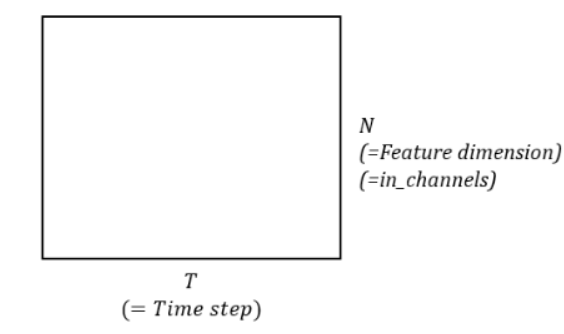

# 데이터 로더

In [17]:
EPOCHS = 100
BATCH_SIZE = 32
lr = 1e-3

In [18]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [19]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [20]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([32, 720, 11]) type: torch.FloatTensor
Y_train :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


In [21]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([32, 720, 11]) type: torch.FloatTensor
Y_valid :  torch.Size([32, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [22]:
lstm = nn.LSTM(input_size=11, hidden_size=256, batch_first=True, bidirectional=True)

lstm(X_valid)[0].size()

torch.Size([32, 720, 512])

In [23]:
lstm(X_valid)[0][-1].size()

torch.Size([720, 512])

In [24]:
lstm(X_valid)[1][0]

tensor([[[-1.2125e-25, -1.4013e-45,  0.0000e+00,  ..., -5.1394e-19,
           6.8985e-01, -1.0000e+00],
         [-5.8491e-01,  1.0684e-19,  2.1312e-14,  ..., -3.1170e-09,
           1.6982e-02, -1.0000e+00],
         [ 7.3319e-01,  1.6223e-08, -6.1830e-09,  ..., -8.1642e-10,
           9.3561e-12, -8.9369e-01],
         ...,
         [-8.6499e-09, -1.3424e-05,  8.0603e-12,  ..., -3.2270e-01,
           9.9617e-01, -9.8948e-01],
         [-1.3622e-11, -4.6491e-16,  2.0828e-14,  ..., -6.7423e-01,
           1.0000e+00, -1.0000e+00],
         [-2.0173e-07, -1.1269e-07,  1.0179e-08,  ..., -3.8466e-01,
           9.1497e-01, -9.2854e-01]],

        [[ 3.0079e-26,  1.0000e+00,  1.5087e-10,  ...,  7.7090e-01,
          -3.0077e-14,  1.5602e-05],
         [ 1.6971e-09,  1.0000e+00, -4.4272e-02,  ...,  1.0077e-01,
          -2.7454e-10,  6.0517e-01],
         [ 1.8537e-17,  1.0000e+00,  1.5693e-10,  ...,  9.9105e-01,
           1.5102e-07,  2.7399e-03],
         ...,
         [-0.0000e+00, -1

In [25]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([32, 512])

In [37]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [38]:
lsenc=lstm_encoder(input_size=11, hidden_size=256)

In [39]:
X_valid.unsqueeze(-1).size()

torch.Size([32, 720, 11, 1])

In [40]:

hidden=lsenc(X_valid)[1]

In [33]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [74]:
X_valid[:,-1,:].unsqueeze(-1).shape

torch.Size([32, 11, 1])

In [75]:
hidden

(tensor([[[-9.9999e-01,  6.8152e-04, -9.9981e-01,  ..., -8.2503e-09,
            1.8485e-10, -1.0000e+00],
          [-9.9918e-01, -5.3212e-02, -9.2547e-01,  ..., -1.7359e-02,
            1.1456e-05, -8.3623e-01],
          [-9.5273e-01, -1.7715e-07,  1.6893e-12,  ..., -1.7547e-16,
            1.0743e-05, -1.0000e+00],
          ...,
          [-3.5726e-01, -9.8880e-01, -4.0953e-01,  ..., -9.6264e-01,
            2.5253e-01,  5.0742e-05],
          [-4.8646e-01, -1.3008e-06, -5.5859e-04,  ..., -2.4223e-01,
            5.7998e-01, -6.8880e-01],
          [-4.2787e-04,  9.2575e-01, -8.4763e-02,  ..., -9.4322e-01,
            7.0677e-01,  5.9411e-04]]], grad_fn=<StackBackward0>),
 tensor([[[-2.6212e+02,  4.2680e+00, -2.8583e+02,  ..., -8.5149e-09,
            3.8020e-04, -7.6464e+01],
          [-5.6660e+01, -3.2140e-01, -1.5016e+01,  ..., -2.1822e-02,
            3.1523e-05, -1.2088e+00],
          [-1.9117e+00, -8.4791e-01,  1.6893e-12,  ..., -1.7550e-16,
            1.2152e+00, -2.4560

In [76]:
X_valid[:,-1,:].shape

torch.Size([32, 11])

In [41]:
lsde = lstm_decoder(input_size=11, hidden_size=256)
lsde(X_valid[:,-1,:] , hidden)

(tensor([[[ 0.3666, -0.2341, -0.1539, -0.0519,  0.0985,  0.1312,  0.0920,
           -0.0640,  0.4623,  0.2326,  0.2723]],
 
         [[-0.1382, -0.3967, -0.1811, -0.0653, -0.3343, -0.2210, -0.0997,
           -0.1103, -0.0185,  0.0250, -0.0885]],
 
         [[ 0.3870, -0.0714, -0.2172, -0.0700, -0.0418,  0.3539,  0.0987,
           -0.2404,  0.2467,  0.2317, -0.0233]],
 
         [[-0.1444, -0.5239,  0.1881,  0.0054, -0.1316,  0.1250,  0.3037,
           -0.0329, -0.0814,  0.1071, -0.0014]],
 
         [[-0.1105, -0.2824, -0.2677,  0.0718, -0.5790,  0.4682,  0.0898,
           -0.4959, -0.2059, -0.0277, -0.1264]],
 
         [[ 0.1965, -0.0706, -0.3865, -0.3186,  0.2734, -0.1299, -0.0438,
           -0.5726, -0.0649, -0.3698, -0.1067]],
 
         [[-0.1360, -0.1985, -0.2862,  0.1435, -0.6505,  0.3039,  0.3511,
           -0.4397, -0.0957, -0.3001, -0.0420]],
 
         [[-0.3309, -0.4086,  0.0808,  0.1474, -0.1413,  0.1920,  0.1884,
           -0.3709, -0.3092, -0.1988,  0.2635]],
 


In [42]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :] #원래 seq2seq는 이전 프레임의 예측값을 넣어주는데. tf는 실제 타겟값으로 넣어준다.
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [43]:
X_valid.size()

torch.Size([32, 720, 11])

In [44]:
Y_valid.unsqueeze(-1).size()

torch.Size([32, 288, 1])

In [45]:
lsed=lstm_encoder_decoder(11,256)
lsed(inputs=X_valid,targets=Y_valid.unsqueeze(-1), target_len=288, teacher_forcing_ratio=0.6)

## 11 ->1 이 되도록 수정이 필요하다.

RuntimeError: input.size(-1) must be equal to input_size. Expected 11, got 1

In [25]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.LSTM(input_size=11, hidden_size=256, batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(512,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.classifier(output[:,-1,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [27]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    train_loss/=len(train_loader.dataset)
    train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss



In [28]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X,) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    valid_loss/=len(valid_loader.dataset)
    valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [29]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_seq2seq.pt'
print(check_path)
model = lstm_encoder_decoder(11,256).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_seq2seq.pt


TypeError: forward() missing 3 required positional arguments: 'targets', 'target_len', and 'teacher_forcing_ratio'

In [ ]:
ddddd

# validation 확인

In [ ]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

In [ ]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

# TEST

In [ ]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]

test_data = test_data.drop(["TurbID", "Day"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [ ]:
test_data.shape

In [ ]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [ ]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [ ]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline.pt')
model.load_state_dict(best_checkpoint)
model.eval()

In [ ]:
preds = predict(model, test_loader)
preds = preds.reshape(-1)

In [ ]:
sample_submission["Patv"] = preds
sample_submission.to_csv("./submit.csv", index = False)